<a href="https://colab.research.google.com/github/SonaArajyan03/ML_prediction_for_energy/blob/main/ML_prediction_for_energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The goal is to obtain the desired state at the final moment with the least possible mechanical energy expenditure.

Imports and Setup

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from scipy.optimize import curve_fit



Load Dataset

In [10]:
data_path = r"/content/dirty_augmented_rod_vibration_data.csv"

data = pd.read_csv(data_path)

In [11]:

data_info = {
    "shape": data.shape,
    "columns": data.columns.tolist(),
    "nulls": data.isnull().sum(),
    "dtypes": data.dtypes
}

print(data_info)


{'shape': (1510, 8), 'columns': ['Rod_Length', 'Young_Modulus', 'Density', 'Damping_Coefficient', 'Boundary_Condition', 'Adhesive_Type', 'Total_Energy', 'Contact_Stress'], 'nulls': Rod_Length             45
Young_Modulus          45
Density                44
Damping_Coefficient    45
Boundary_Condition      0
Adhesive_Type           0
Total_Energy            0
Contact_Stress         75
dtype: int64, 'dtypes': Rod_Length              object
Young_Modulus          float64
Density                float64
Damping_Coefficient    float64
Boundary_Condition      object
Adhesive_Type           object
Total_Energy           float64
Contact_Stress         float64
dtype: object}


Preprocessing Function

>Converts Rod_Length to numeric, fills missing numeric values with median, one-hot encodes categorical variables, and creates a binary target column Minimized.



In [12]:
# # Փոխել Rod_Length-ը թվայինի
# data["Rod_Length"] = pd.to_numeric(data["Rod_Length"], errors="coerce")

# # Լրացնել բաց արժեքները median-ներով թվային սյունակների համար
# numeric_cols = data.select_dtypes(include=["float64", "int64"]).columns
# data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# # Կոդավորել կատեգորիկ սյունակները
# data_encoded = pd.get_dummies(data, columns=["Boundary_Condition", "Adhesive_Type"], drop_first=True)

# # Ստեղծել թիրախային սյուն՝ Minimized
# data_encoded["Minimized"] = data_encoded["Total_Energy"] < data_encoded["Total_Energy"].mean()


def preprocess_data(data):
    # Convert Rod_Length to numeric
    data["Rod_Length"] = pd.to_numeric(data["Rod_Length"], errors="coerce")
    # Fill missing numeric values with median
    numeric_cols = data.select_dtypes(include=["float64", "int64"]).columns
    data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())
    # One-hot encode categorical features
    data_encoded = pd.get_dummies(data, columns=["Boundary_Condition", "Adhesive_Type"], drop_first=True)
    # Create binary target column: True if energy is below average
    data_encoded["Minimized"] = data_encoded["Total_Energy"] < data_encoded["Total_Energy"].mean()
    return data_encoded
data_encoded = preprocess_data(data)



 Feature Engineering

In [13]:
# Discretizes Contact_Stress into 10 bins for later statistical analysis. (ոչ One-Hot encoded)
data_encoded["Contact_Stress_Bin_Cut"] = pd.cut(data_encoded["Contact_Stress"], bins=10)


 Train + Evaluate Function


In [14]:

def train_evaluate_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    return model

Model Training

In [15]:
target = "Minimized"
features = data_encoded.drop(columns=["Total_Energy", target, "Contact_Stress_Bin_Cut"])

model = RandomForestClassifier(random_state=42)
model = train_evaluate_model(model, features, data_encoded[target])


Confusion Matrix:
 [[103  10]
 [  3 186]]

Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.91      0.94       113
        True       0.95      0.98      0.97       189

    accuracy                           0.96       302
   macro avg       0.96      0.95      0.95       302
weighted avg       0.96      0.96      0.96       302

Accuracy: 0.96


Cross-Validation

In [16]:
# Performs 5-fold cross-validation to validate the model's robustness.
cv_scores = cross_val_score(model, features, data_encoded[target], cv=5)
print(f"\nAverage Cross-Validation Accuracy: {cv_scores.mean():.2f}")



Average Cross-Validation Accuracy: 0.96


In [ ]:
# Saveing fitting model
joblib.dump(model, "random_forest_model.pkl")


['random_forest_model.pkl']

 Feature Importance

In [17]:
# Calculates and plots feature importances.
importances = model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": features.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

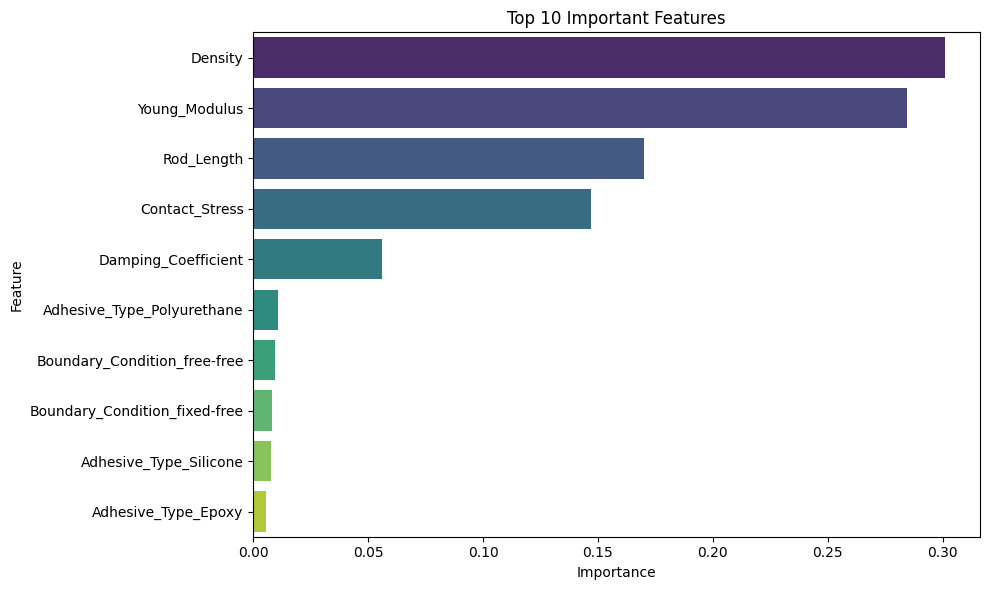

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=importance_df.head(10),
    x="Importance",
    y="Feature",
    hue="Feature",
    palette="viridis",
    legend=False
)
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


 Binned Target Probability Plot
> Groups data by Contact_Stress bins and visualizes average probability of minimization.



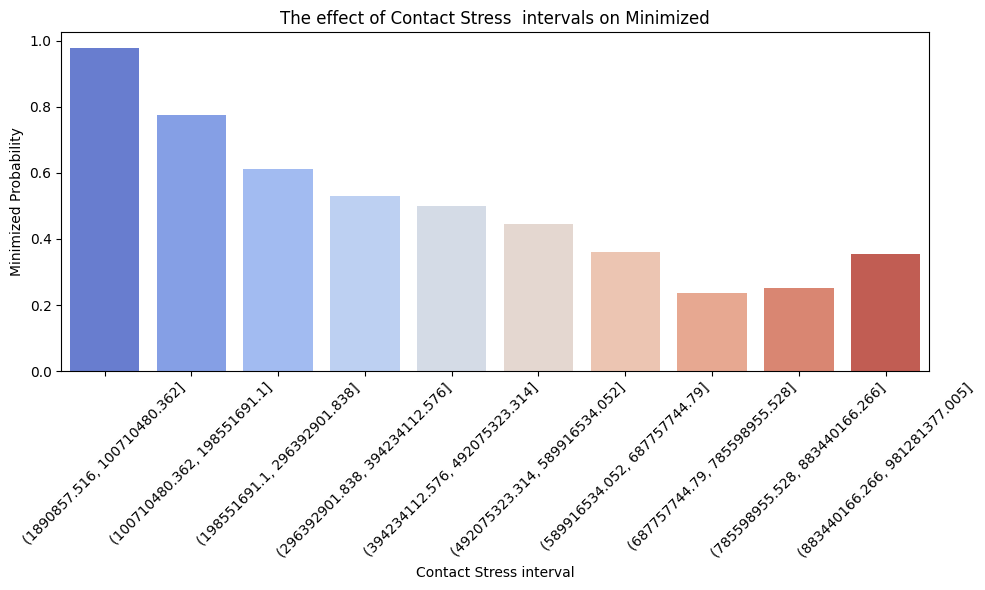

In [21]:
#  Minimized Probability by Contact Stress Binը
data_encoded["Contact_Stress_Bin"] = pd.cut(data_encoded["Contact_Stress"], bins=10)

# Attention - we use observed=True to avoid warnings.
bin_summary = data_encoded.groupby("Contact_Stress_Bin", observed=True)["Minimized"].mean().reset_index()

# In the drawing, we pass the hue as x and disable the legend.
plt.figure(figsize=(10,6))
sns.barplot(x="Contact_Stress_Bin", y="Minimized", hue="Contact_Stress_Bin", data=bin_summary, palette="coolwarm", legend=False)
plt.xticks(rotation=45)
plt.title("The effect of Contact Stress  intervals on Minimized")
plt.ylabel("Minimized Probability")
plt.xlabel("Contact Stress interval")
plt.tight_layout()
plt.show()



 Power-Law Curve Fitting

> Fits a power-law model to describe the relationship between Contact_Stress and energetic loss.



Fitted parameters: k = 2.98e-06, n = 0.60


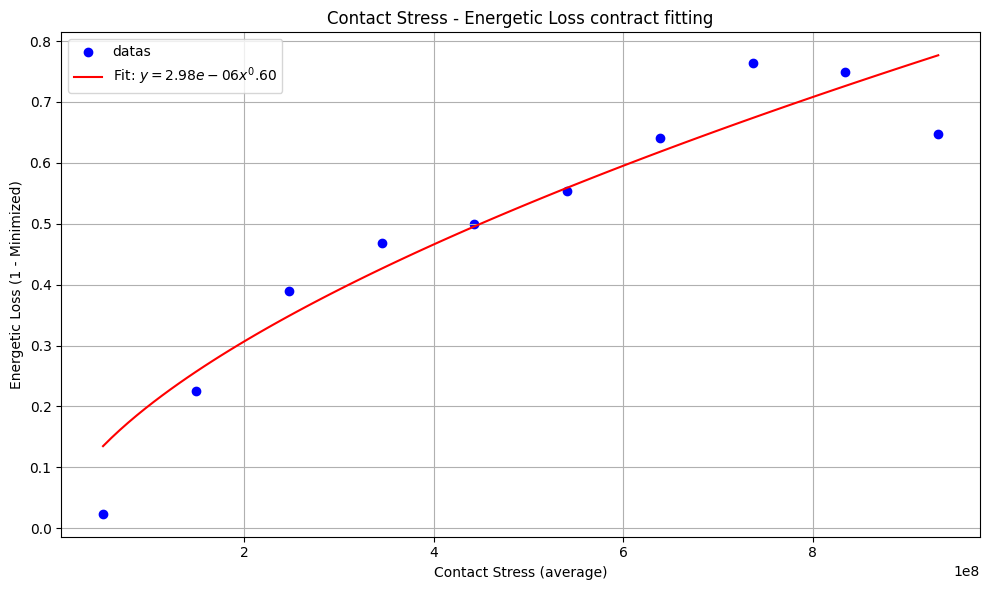

In [23]:
# Average probability of Minimizing contact Contract Stress using bin
bin_summary = data_encoded.groupby("Contact_Stress_Bin_Cut", observed=True)["Minimized"].mean().reset_index()

#fitting
bin_centers = bin_summary["Contact_Stress_Bin_Cut"].apply(lambda x: (x.left + x.right) / 2).astype(float).values
minimized_mean = bin_summary["Minimized"].values
energetic_loss = 1 - minimized_mean

# model y = k * x^n
def model_func(x, k, n):
    return k * x**n

# fitting
popt, pcov = curve_fit(model_func, bin_centers, energetic_loss, p0=[1e-6, 1])
k_fit, n_fit = popt
print(f"Fitted parameters: k = {k_fit:.2e}, n = {n_fit:.2f}")

x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 100)
y_fit = model_func(x_fit, *popt)

plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, energetic_loss, color='blue', label="datas")
plt.plot(x_fit, y_fit, color='red', label=f"Fit: $y={k_fit:.2e} x^{n_fit:.2f}$")
plt.xlabel("Contact Stress (average)")
plt.ylabel("Energetic Loss (1 - Minimized)")
plt.title("Contact Stress - Energetic Loss contract fitting")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The light blue dots represent the real data points,

The red curve shows the fitted model.

The output displays the values of k and n.


* Mathematically — if n > 0, it is physically valid: an increase in Contact
* Stress leads to an increase in Energetic Loss  
* If n = 1, there is an approximately linear relationship.
* If n > 1, the dependence is nonlinear and grows rapidly.





 Theoretical Model Fitting

 > Fits a more complex theoretical model using a hyperbolic cosine-based function.


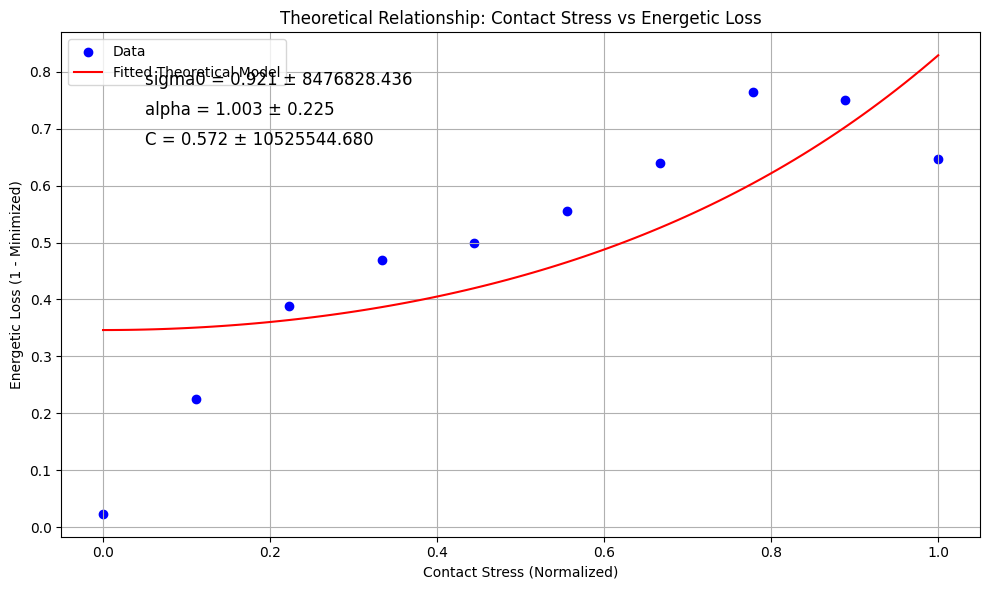

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Theoretical model
def model_func(x, sigma0, alpha, C):
    term = (sigma0 * np.cosh(alpha * x)) / (alpha * np.sinh(alpha))
    return C * term**2

# Normalize the data
bin_centers_norm = (bin_centers - np.min(bin_centers)) / (np.max(bin_centers) - np.min(bin_centers))  # We normalized the data within the range from 0 to 1

# Fitting function
params, covariance = curve_fit(model_func, bin_centers_norm, energetic_loss, p0=[1.0, 2.0, 1.0])

# Obtained frequencies and errors
sigma0_fit, alpha_fit, C_fit = params
sigma0_err, alpha_err, C_err = np.sqrt(np.diag(covariance))

x_fit = np.linspace(bin_centers_norm.min(), bin_centers_norm.max(), 100)
y_fit = model_func(x_fit, *params)

plt.figure(figsize=(10, 6))
plt.scatter(bin_centers_norm, energetic_loss, color='blue', label="Data")
plt.plot(x_fit, y_fit, color='red', label="Fitted Theoretical Model")
plt.xlabel("Contact Stress (Normalized)")
plt.ylabel("Energetic Loss (1 - Minimized)")
plt.title("Theoretical Relationship: Contact Stress vs Energetic Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Add display of fitting results
plt.figtext(0.15, 0.85, f"sigma0 = {sigma0_fit:.3f} ± {sigma0_err:.3f}", fontsize=12)
plt.figtext(0.15, 0.80, f"alpha = {alpha_fit:.3f} ± {alpha_err:.3f}", fontsize=12)
plt.figtext(0.15, 0.75, f"C = {C_fit:.3f} ± {C_err:.3f}", fontsize=12)

plt.show()



